### Import modules, define functions, define general input files and variables

In [1]:
import sys
# sys.path.append('../')
# import deeprank_plots as dp
import os
import h5py
import numpy as np
from numpy.polynomial.polynomial import polyfit
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import sys
sys.path.append('/home/dmarz/3D-Vac/src/5_train_models')
from DeepRank import classMetrics
from sklearn.metrics import average_precision_score as auprc

import pickle

def get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLA_all.pkl'):
    with open(pklname, 'rb') as inpkl:
        name = pickle.load(inpkl)
        seq = pickle.load(inpkl)
        score = pickle.load(inpkl)
        dist = pickle.load(inpkl)

    matrix = {}
    for i, x in enumerate(name):
        matrix[x] = { y:dist[i+j]  for j, y in enumerate(name[i+1:])}
    
    return matrix

def get_avg_distance(allele, matrix, test_alleles):
    distances = []
    other_alleles = [name for name in matrix.keys() if (name not in test_alleles) and (name != allele)]
    for name in other_alleles:
        if name not in training_allele_freq.keys():
            #print(f'WARNING: allele {allele} not in training alleles frequency')
            if name in test_alleles:
                #print(f'Health check: {allele} in test alleles')
                continue
            else:
                #print(f'WARNING: allele {name} not in training alleles. Skipping.')
                continue
        
        try:
            distances.append(matrix[allele][name] * training_allele_freq[name]) 
        except KeyError:
            try:
                distances.append(matrix[name][allele] * training_allele_freq[name])
            except KeyError:
                raise KeyError('The provided allele does not seem to belong to this matrix')

    avg_distance = sum(distances)/len(distances)
    return avg_distance

matrix = {}
matrix['A'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAA.pkl')
matrix['B'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAB.pkl')
matrix['C'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAC.pkl')
matrix['ALL'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLA_all.pkl')


# clust_dfi = pd.read_csv('/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_pseudoseq_clustered_test.csv')
# clust_dfi['label'] = np.where(clust_dfi['measurement_value'] < 500, 1.0, 0.0)
clust_dfi = pd.read_csv('/projects/0/einf2380/data/external/processed/I/CrossValidations/AlleleClustered/test.csv')

tdf=pd.read_csv(
    '/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_pseudoseq_clustered_train_validation.csv')
training_allele_freq = {}
for allele in list(set(tdf['allele'])):
    training_allele_freq[allele] = (tdf['allele'] == allele).sum()/len(tdf)

test_alleles = list(set(clust_dfi['allele']))

correlations = {}

label_per_model = {'CNN': ('OUTPUT_1', 'TARGET'),
                    'GNN': ('output', 'label'),
                'EGNN': ('OUTPUT_1', 'TARGET'),
                'SSL': ('OUTPUT_1', 'TARGET'),
                'MLP': ('OUTPUT_1', 'label'),
                'MHCflurry': ('OUTPUT_1', 'label'),
                }

### Get the models output for every model and plot AUC vs evolutionary distance from the training set per allele

In [2]:
def get_model_output(title, dfot, dfi):
    ## Get output and distance per allele
    allele_outputs = {}
    title = title.split('_')[0]
    outputs_key = label_per_model[title][0]
    labels_key = label_per_model[title][1]
    
    for allele in test_alleles:
        #gene = allele.split('*')[0].split('-')[1]
        if allele in matrix['ALL'].keys():
            #identify all the allele's IDs
            IDs = dfi.loc[dfi['allele'] == allele, 'ID'].values
            dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
            if len(dfauc)>0:
                allele_outputs[allele] = {}
                auc = classMetrics.roc_auc(dfauc[outputs_key], dfauc[labels_key])
                allele_outputs[allele]['auc'] = auc
                allele_outputs[allele]['distance']= get_avg_distance(allele, matrix['ALL'], test_alleles) #matrix[gene]
        else:
            print(f'Allele {allele} not in Matrix ALL')
        
    #total AUC
    IDs = dfi['ID'].values
    dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
    allele_outputs['total_auc'] = classMetrics.roc_auc(dfauc[outputs_key], dfauc[labels_key])
    allele_outputs['total_auprc'] = auprc(dfauc[labels_key], dfauc[outputs_key])
    print(f'TITLE {title}, AUC {allele_outputs["total_auc"]}')
    
    return allele_outputs

def get_shuff_auc(title, dfot, dfi):
    IDs = dfi['ID'].values
    title = title.split('_')[0]
    outputs_key = label_per_model[title][0]
    labels_key = label_per_model[title][1]
    dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
    return classMetrics.roc_auc(dfauc[outputs_key], dfauc[labels_key])

def get_shuff_auprc(title, dfot, dfi):
    IDs = dfi['ID'].values
    title = title.split('_')[0]
    outputs_key = label_per_model[title][0]
    labels_key = label_per_model[title][1]
    dfauc = pd.merge(dfi[dfi['ID'].isin(IDs)], dfot[dfot['ID'].isin(IDs)], on='ID')
    return auprc(dfauc[labels_key], dfauc[outputs_key])


models_outputs = {}

title = 'CNN'
models_outputs[title] = {}
for fold in range(1,6):
    #%% CNN outputs
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/cnn_outputs/allele_crossval/allele_cnn_outputs_fold_{fold}.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('testing', case=False)]
    dfot['TARGET'] = dfot['TARGET'].astype(float)
    dfot['ID'] = dfot['KEY']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)

# GNN outputs
title = 'GNN'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/gnn_outputs/allele_crossval/allele_gnn_outputs_n_run_{fold}.csv')

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)

#%% EGNN outputs
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

title = 'EGNN'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/egnn_outputs/allele_crossval/AlleleClustered_{fold}_final_test_test_results.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
    dfot['OUTPUT_1']=sigmoid(dfot['Output'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)


#%% MHCflurry outputs
title='MHCflurry'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/mhcflurry_outputs/allele_mhcflurry_outputs.csv',
                header=None, names=['ID', 'BA', 'OUTPUT_1'])

models_outputs[title] = get_model_output(title, dfo, clust_dfi)

#%% MLP 
title='MLP'
models_outputs[title] = {}
for fold in range(1,6):
    dfo = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/mlp_outputs/allele_crossval/AlleleClustered_{fold}.csv')

    models_outputs[title][fold] = get_model_output(title, dfo, clust_dfi)

#%% SSL without TCRs outputs

title = 'SSL_woT'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_ssl_no_tcr_allele.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

models_outputs[title] = get_model_output(title, dfot, clust_dfi)

title = 'SSL_T'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pMHCI/trained_models/3DSSL/xray_{fold}_test_results.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
    dfot['OUTPUT_1']=sigmoid(dfot['Log_prob'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)
    
title = 'SSL_1k'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pMHCI/trained_models/3DSSL/pandora_1k_{fold}_test_results.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
    dfot['OUTPUT_1']=sigmoid(dfot['Log_prob'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)
    
title = 'SSL_5k'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pMHCI/trained_models/3DSSL/pandora_5k_{fold}_test_results.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
    dfot['OUTPUT_1']=sigmoid(dfot['Log_prob'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)
    
title = 'SSL_10k'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pMHCI/trained_models/3DSSL/pandora_10k_{fold}_test_results.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
    dfot['OUTPUT_1']=sigmoid(dfot['Log_prob'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)
    
title = 'SSL_all'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pMHCI/trained_models/3DSSL/pandora_all_{fold}_test_results.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
    dfot['OUTPUT_1']=sigmoid(dfot['Log_prob'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)
    
title = 'SSL_xray_pandora'
models_outputs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pMHCI/trained_models/3DSSL/xray_pandora_all_{fold}_test_results.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
    dfot['OUTPUT_1']=sigmoid(dfot['Log_prob'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    models_outputs[title][fold] = get_model_output(title, dfot, clust_dfi)




TITLE CNN, AUC 0.6930787406249957
TITLE CNN, AUC 0.6878341944280988
TITLE CNN, AUC 0.6903267818565179
TITLE CNN, AUC 0.7191671179686225
TITLE CNN, AUC 0.7015906528204776
TITLE GNN, AUC 0.7092782658454698
TITLE GNN, AUC 0.7336012541943201
TITLE GNN, AUC 0.7344766554869183
TITLE GNN, AUC 0.7010897239420895
TITLE GNN, AUC 0.6956768470084713
TITLE EGNN, AUC 0.7382224767996637
TITLE EGNN, AUC 0.7264746114383849
TITLE EGNN, AUC 0.7130166555979716
TITLE EGNN, AUC 0.7134472958238249
TITLE EGNN, AUC 0.7292494049717004
TITLE MHCflurry, AUC 0.6546790015053261
TITLE MLP, AUC 0.6671806522834605
TITLE MLP, AUC 0.486548587507768
TITLE MLP, AUC 0.47850901106797955
TITLE MLP, AUC 0.5539148155635133
TITLE MLP, AUC 0.5991302790277954
TITLE SSL, AUC 0.6415857406790357
TITLE SSL, AUC 0.6811632197879242
TITLE SSL, AUC 0.6593365780116895
TITLE SSL, AUC 0.6730005727610489
TITLE SSL, AUC 0.6521137961163166
TITLE SSL, AUC 0.6626292665465534
TITLE SSL, AUC 0.5678657676655686
TITLE SSL, AUC 0.5538158199687816
TIT

In [3]:
models_outputs['SSL_T']

{1: {'HLA-C*07:02': {'auc': 0.45052083333333337,
   'distance': 2.572262338534587},
  'HLA-C*07:01': {'auc': 0.4285714285714286, 'distance': 2.476456802782781},
  'HLA-B*57:01': {'auc': 0.6797427442661256, 'distance': 1.6820218860872325},
  'HLA-A*80:01': {'auc': 0.5675, 'distance': 1.533499026373807},
  'HLA-B*58:02': {'auc': 0.7696969696969698, 'distance': 1.9761651040160806},
  'HLA-B*58:01': {'auc': 0.7172977604073912, 'distance': 1.8474604009795539},
  'HLA-A*24:02': {'auc': 0.6469768267649177, 'distance': 1.475550758757997},
  'HLA-B*57:03': {'auc': 0.8148148148148149, 'distance': 1.5215284225220425},
  'HLA-B*57:02': {'auc': 0.6071428571428571, 'distance': 1.6234347903905226},
  'HLA-A*23:01': {'auc': 0.63533572094983, 'distance': 1.384291246223569},
  'HLA-A*01:01': {'auc': 0.6873106485030764, 'distance': 1.5214139698148943},
  'HLA-B*15:17': {'auc': 0.5828042328042329, 'distance': 2.0049060224751116},
  'HLA-A*24:03': {'auc': 0.7127285513361464, 'distance': 1.4592600440930255}

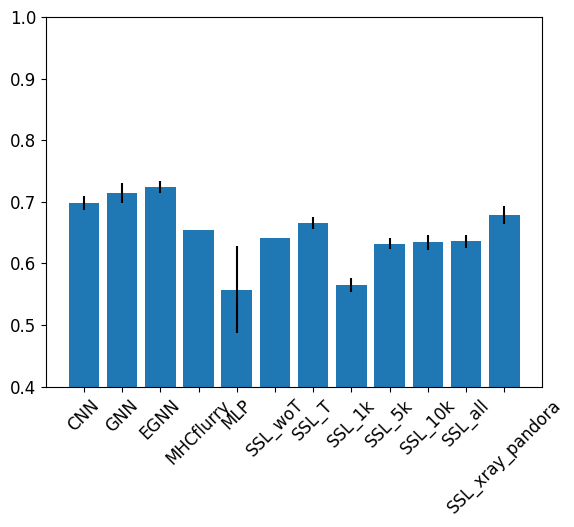

In [21]:

#%% Plot barplots

#fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
layout = go.Layout(
    autosize=False,
    width=1200,
    height=400
)
fig = go.Figure(layout=layout)

correlations = {}

# Iterate over the allele_outputs dictionary and titles list
for i, title in enumerate(['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']):
    if title == 'MHCflurry':
        allele_outputs = models_outputs[title]

        # Extract sample names and values from the dictionary
        labels = [f"{x} D:{allele_outputs[x]['distance']:.1f} N={(clust_dfi['allele'] == x).sum()}" for x in allele_outputs if 'total' not in x]
        labels.sort(key=lambda x: float(x.split(' ')[1].split(':')[1]))
        #labels = [f"{x} N={(clust_dfi['allele'] == x).sum()}" for x in allele_outputs if 'total' not in x]
        ordered_alleles = [x.split(' ')[0] for x in labels]
        values = [allele_outputs[x]['auc'] for x in ordered_alleles]

        # Create a Plotly bar plot
        labels = [f'{x.split(" ")[0]} {x.split(" ")[2]}'  for x in labels]
        fig.add_trace(go.Bar(x=labels, y=values, name=title))
    else:
        folds_aucs = {}
        for fold in models_outputs[title]:
            allele_outputs = models_outputs[title][fold]
            
            if fold == 1:
                labels = [f"{x} D:{allele_outputs[x]['distance']:.1f} N={(clust_dfi['allele'] == x).sum()}" for x in allele_outputs if 'total' not in x]
                #labels = [f"{x} N={(clust_dfi['allele'] == x).sum()}" for x in allele_outputs if 'total' not in x]
            labels.sort(key=lambda x: float(x.split(' ')[1].split(':')[1]))
            ordered_alleles = [x.split(' ')[0] for x in labels]
            folds_aucs[fold] = np.asarray([allele_outputs[x]['auc'] for x in ordered_alleles])
            
        Y = np.mean([x for x in folds_aucs.values()], axis=0)
        errors = np.std([x for x in folds_aucs.values()], axis=0)
            

        # # Extract sample names and values from the dictionary
        # labels = [f"{x} D:{allele_outputs[x]['distance']:.1f} N{(clust_dfi['allele'] == x).sum()}" for x in allele_outputs if 'total' not in x]
        # values = [allele_outputs[x]['auc'] for x in allele_outputs if 'total' not in x]

        # Create a Plotly bar plot
        #labels.sort(key=lambda x: float(x.split(' ')[1].split(':')[1]))
        labels = [f'{x.split(" ")[0]} {x.split(" ")[2]}'  for x in labels]
        fig.add_trace(go.Bar(x=labels, y=Y, name=title, error_y=dict(type='data', array=errors)))


    # Customize the layout if needed
fig.update_layout(title='AUC per test allele', xaxis_title='Allele name and samples per allele', yaxis_title='AUC',
                  yaxis = dict(tickmode = 'linear', dtick=0.1), yaxis_range=[0.0,1.0] )
fig.add_hline(y=0.5, line_dash="dash")

# Adjust layout and show the plot
# plt.tight_layout()
fig.show()
fig.write_image("/home/dmarz/3D-Vac/src/exploration/manuscript/figures/AUCperAllele.pdf", engine="kaleido")
'''
#%% Plot regplot

fig, axes = plt.subplots(1, len(models_outputs), figsize=(20, 5), sharey=True)
correlations = {}

# Iterate over the allele_outputs dictionary and titles list
for i, title in enumerate(models_outputs.keys()):
    allele_outputs = models_outputs[title]
    x = [allele_outputs[x]['distance'] for x in allele_outputs if 'total' not in x]
    y = [allele_outputs[x]['auc'] for x in allele_outputs if 'total' not in x]
    
    correlations[title] = np.corrcoef(x, y)[0][1]
    
    # Create scatter plot with regression line
    sns.regplot(x=x, y=y, ci=99, n_boot=1000, ax=axes[i]) #lowess=True)
    axes[i].axhline(0.5, linestyle='-.', color='red', label='Baseline')
    axes[i].axhline(np.mean(y), linestyle='--', color='green', label='Average AUC')
    axes[i].axhline(np.mean(allele_outputs['total_auc']), linestyle='--', color='cyan', label='Total AUC')
    
    # Customize individual subplot
    axes[i].set_title(f'{title} Pearson:{correlations[title]:.2f}')
    axes[i].set_xlabel('Evo distance from training')
    axes[i].set_ylabel('AUC')
    
    if i == 0:
        axes[i].legend(labels=['Sample', 'Regression', 'Confidence Interval', 'Random Predictor', 'Average (un-weighted) AUC', 'Total AUC'])

# Set common y-label for all subplots
axes[0].set_ylabel('AUC')
axes[0].set_ylim(0,1.0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#%% Plot scatterplot

fig, axes = plt.subplots(1, len(models_outputs), figsize=(20, 5), sharey=True)
correlations = {}

# Iterate over the allele_outputs dictionary and titles list
for i, title in enumerate(models_outputs.keys()):
    allele_outputs = models_outputs[title]
    x = [allele_outputs[x]['distance'] for x in allele_outputs if 'total' not in x]
    y = [allele_outputs[x]['auc'] for x in allele_outputs if 'total' not in x]
    
    correlations[title] = np.corrcoef(x, y)[0][1]
    
    # Create scatter plot with regression line
    axes[i].plot(x, y, '.') #lowess=True)
    axes[i].axhline(0.5, linestyle='-.', color='red', label='Baseline')
    #axes[i].axhline(np.mean(y), linestyle='--', color='green', label='Average AUC')
    #axes[i].axhline(np.mean(allele_outputs['total_auc']), linestyle='--', color='cyan', label='Total AUC')
    
    # Customize individual subplot
    axes[i].set_title(f'{title} Pearson:{correlations[title]:.2f}')
    axes[i].set_xlabel('Evo distance from training')
    axes[i].set_ylabel('AUC')
    
    if i == 0:
        axes[i].legend(labels=['Sample', 'Random Predictor'])

# Set common y-label for all subplots
axes[0].set_ylabel('AUC')
axes[0].set_ylim(0,1.0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

plt.clf()

'''
plt.rcParams['font.size'] = 12
collected_allele_outputs = {}
for title in models_outputs:
    collected_allele_outputs[title] = {}
    if title == 'MHCflurry' or title == 'SSL_woT':
        collected_allele_outputs[title]['total_auc'] = models_outputs[title]['total_auc']
        collected_allele_outputs[title]['auc_stdev'] = 0
        
        collected_allele_outputs[title]['total_auprc'] = models_outputs[title]['total_auprc']
        collected_allele_outputs[title]['auprc_stdev'] = 0
    
    else:
        collected_allele_outputs[title]['total_auc'] = np.mean([models_outputs[title][fold]['total_auc'] for fold in models_outputs[title]])
        collected_allele_outputs[title]['auc_stdev'] = np.std([models_outputs[title][fold]['total_auc'] for fold in models_outputs[title]])
        
        collected_allele_outputs[title]['total_auprc'] = np.mean([models_outputs[title][fold]['total_auprc'] for fold in models_outputs[title]])
        collected_allele_outputs[title]['auprc_stdev'] = np.std([models_outputs[title][fold]['total_auprc'] for fold in models_outputs[title]])
            
            

plt.bar(x=[x for x in collected_allele_outputs], 
        height=[collected_allele_outputs[x]['total_auc'] for x in collected_allele_outputs],
        yerr=[collected_allele_outputs[x]['auc_stdev'] for x in collected_allele_outputs])

plt.xticks(rotation=45)
plt.ylim(0.4,1.0)
plt.show()

# fig = go.Figure()
# for x in models_outputs:
#     fig.add_trace(go.Bar(x=models_outputs[x], y=models_outputs[x]['total_auc'], name=title))


In [23]:
collected_allele_outputs['EGNN']

{'total_auc': 0.7240820889263091,
 'auc_stdev': 0.009673867141626347,
 'total_auprc': 0.6301585334621459,
 'auprc_stdev': 0.0063395615371645495}

### Plot shuffled set performances

In [6]:

#%% Shuffled performances

#dfi = pd.read_csv('/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_pseudoseq_clustered_test.csv')
shuff_dfi = pd.read_csv('/projects/0/einf2380/data/external/processed/I/experiments/BA_pMHCI_human_quantitative_only_eq_shuffled_test.csv')
shuff_dfi['label'] = np.where(shuff_dfi['measurement_value'] < 500, 1.0, 0.0)

#models_outputs = {}
AUCs = {}
AUPRCs = {}

title = 'CNN'
AUCs[title] = {}
AUPRCs[title] = {}
for fold in range(1,6):
    #%% CNN outputs
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/cnn_outputs/shuffled_crossval/shuffled_cnn_outputs_fold_{fold}.csv')
    #dfot = dfo[dfo['PHASE'].str.contains('testing', case=False)]
    dfot['TARGET'] = dfot['TARGET'].astype(float)
    dfot['ID'] = dfot['KEY']

    AUCs[title][fold] = get_shuff_auc(title, dfot, shuff_dfi)
    AUPRCs[title][fold] = get_shuff_auprc(title, dfot, shuff_dfi)

# GNN outputs
title = 'GNN'
AUCs[title] = {}
AUPRCs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/gnn_outputs/shuffled_crossval/shuffled_gnn_outputs_n_run_{fold}.csv')

    AUCs[title][fold] = get_shuff_auc(title, dfot, shuff_dfi)
    AUPRCs[title][fold] = get_shuff_auprc(title, dfot, shuff_dfi)


title = 'EGNN'
AUCs[title] = {}
AUPRCs[title] = {}
for fold in range(1,6):
    dfot = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/egnn_outputs/shuffled_crossval/Shuffled_{fold}_final_test_test_results.csv')
    dfot['OUTPUT_1']=sigmoid(dfot['Output'])
    dfot['TARGET'] = dfot['Target'].astype(float)
    dfot['ID'] = dfot['Key']

    AUCs[title][fold] = get_shuff_auc(title, dfot, shuff_dfi)
    AUPRCs[title][fold] = get_shuff_auprc(title, dfot, shuff_dfi)

#%% SSL without TCRs outputs

title = 'SSL_woT'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_ssl_no_tcr_shuffle.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

AUCs[title] = get_shuff_auc(title, dfot, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfot, shuff_dfi)

#%% SSL with TCRs outputs

title = 'SSL_T'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/egnn_outputs/egnn_ssl_shuffle.csv')
dfot = dfo[dfo['PHASE'].str.contains('validation', case=False)]
dfot['OUTPUT_1']=sigmoid(dfot['OUTPUT_0'])
dfot['TARGET'] = dfot['TARGET'].astype(float)
dfot['ID'] = dfot['KEY']

AUCs[title] = get_shuff_auc(title, dfot, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfot, shuff_dfi)


#%% MHCflurry outputs
title='MHCflurry'
dfo = pd.read_csv('/projects/0/einf2380/data/pop_paper_data/mhcflurry_outputs/shuffled_mhcflurry_outputs.csv',
                header=None, names=['ID', 'BA', 'OUTPUT_1'])

AUCs[title] = get_shuff_auc(title, dfo, shuff_dfi)
AUPRCs[title] = get_shuff_auprc(title, dfo, shuff_dfi)

#%% MLP 
title='MLP'
AUCs[title] = {}
AUPRCs[title] = {}
for fold in range(1,6):
    dfo = pd.read_csv(f'/projects/0/einf2380/data/pop_paper_data/mlp_outputs/shuffled_crossval/Shuffled_{fold}.csv')

    AUCs[title][fold] = get_shuff_auc(title, dfo, shuff_dfi)
    AUPRCs[title][fold] = get_shuff_auprc(title, dfo, shuff_dfi)


collected_shuffled_outputs = {}
for title in AUCs:
    collected_shuffled_outputs[title] = {}
    if title == 'MHCflurry' or title.startswith('SSL'):
        collected_shuffled_outputs[title]['total_auc'] = AUCs[title]
        collected_shuffled_outputs[title]['auc_stdev'] = 0
        
        collected_shuffled_outputs[title]['total_auprc'] = AUPRCs[title]
        collected_shuffled_outputs[title]['auprc_stdev'] = 0

    else:
        collected_shuffled_outputs[title]['total_auc'] = np.mean([AUCs[title][fold] for fold in AUCs[title]])
        collected_shuffled_outputs[title]['auc_stdev'] = np.std([AUCs[title][fold] for fold in AUCs[title]])
        
        collected_shuffled_outputs[title]['total_auprc'] = np.mean([AUPRCs[title][fold] for fold in AUPRCs[title]])
        collected_shuffled_outputs[title]['auprc_stdev'] = np.std([AUPRCs[title][fold] for fold in AUPRCs[title]])

#plt.bar(AUCs.keys(), AUCs.values())
fig = go.Figure()
fig.add_trace(go.Bar(x=list(collected_shuffled_outputs.keys()), 
                     y=list([x['total_auc'] for x in collected_shuffled_outputs.values()]),
                     error_y=dict(type='data', array=[x['auc_stdev'] for x in collected_shuffled_outputs.values()])))
fig.show()
AUCs

{'CNN': {1: 0.8496648949257286,
  2: 0.8532753088801709,
  3: 0.862154137542652,
  4: 0.8579630637133244,
  5: 0.8506262908586383},
 'GNN': {1: 0.8355766872323165,
  2: 0.8369068508141355,
  3: 0.8380785268202486,
  4: 0.8277617403445219,
  5: 0.8488877568347768},
 'EGNN': {1: 0.8429657422266422,
  2: 0.8634623932976215,
  3: 0.8652065486819006,
  4: 0.8694859450459207,
  5: 0.8699756647002539},
 'SSL_woT': 0.6523308350407313,
 'SSL_T': 0.6556257029998448,
 'MHCflurry': 0.8146540477715316,
 'MLP': {1: 0.892020583293779,
  2: 0.8869256153515812,
  3: 0.8922880455665303,
  4: 0.9003194478975959,
  5: 0.8946839047984994}}

### Reorder dictionaries for figure plotting

In [7]:
'''
#%% Reorder and rename

allele_aucs = {x: models_outputs[x]['total_auc'] for x in models_outputs}
allele_auprcs = {x: models_outputs[x]['total_auprc'] for x in models_outputs}
#allele_aucs['3D-GPT'] = allele_aucs['SSL_T']
#del allele_aucs['SSL_T']
order = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP', 'SSL_T', 'SSL_woT']
allele_aucs = {x:allele_aucs[x] for x in order}
allele_auprcs = {x:allele_auprcs[x] for x in order}

#AUCs['3D-SSL'] = AUCs['SSL_T']
#del AUCs['SSL_T']
#AUCs.pop('SSL_woT')
#AUCs.pop('SSL_T')
AUCs = {x:AUCs[x] for x in order}
AUPRCs = {x:AUPRCs[x] for x in order}
'''


"\n#%% Reorder and rename\n\nallele_aucs = {x: models_outputs[x]['total_auc'] for x in models_outputs}\nallele_auprcs = {x: models_outputs[x]['total_auprc'] for x in models_outputs}\n#allele_aucs['3D-GPT'] = allele_aucs['SSL_T']\n#del allele_aucs['SSL_T']\norder = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP', 'SSL_T', 'SSL_woT']\nallele_aucs = {x:allele_aucs[x] for x in order}\nallele_auprcs = {x:allele_auprcs[x] for x in order}\n\n#AUCs['3D-SSL'] = AUCs['SSL_T']\n#del AUCs['SSL_T']\n#AUCs.pop('SSL_woT')\n#AUCs.pop('SSL_T')\nAUCs = {x:AUCs[x] for x in order}\nAUPRCs = {x:AUPRCs[x] for x in order}\n"

### Barplot plotting for the manuscript

In [8]:
def plot_barplot(x, y, error, color, xlabel, ylabel, title,
                save=False, ylim=(0.5, 1.0), 
                decimals=3, baseline=False):
    fig, ax = plt.subplots(1,1)

    # Save the chart so we can loop through the bars below.
    bars = plt.bar(
        x=x,
        height=y,
        yerr=error,
        capsize=4,
        tick_label=x,
        color=color,
        error_kw=dict(ecolor='gray')
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    ax.set_ylim(ylim)
    if baseline:
        plt.axhline(baseline, linestyle='-.', color='grey')

    #ax.legend(x)
    
    # Add text annotations to the top of the bars.
    #bar_color = bars[0].get_facecolor()
    for bar in bars:
        if decimals == 2:
            bar_text = f'{bar.get_height():.2f}'
        else:
            bar_text = f'{bar.get_height():.3f}'
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.02,
            bar_text,
            horizontalalignment='center',
            color=bar.get_facecolor(),
            weight='bold'
        )

    # Add labels and a title.
    ax.set_xlabel(xlabel, labelpad=15, color='#333333')
    ax.set_ylabel(ylabel, labelpad=15, color='#333333')
    ax.set_title(title, pad=15, color='#333333',
                weight='bold')

    
    fig.tight_layout()
    
    if save:
        plt.savefig(f'{save}.png', dpi=400)
        plt.savefig(f'{save}.pdf')


### PLOT AUCs

In [9]:
collected_allele_outputs

{'CNN': {'total_auc': 0.6983994975397425,
  'auc_stdev': 0.011371739996963648,
  'total_auprc': 0.5909201924808454,
  'auprc_stdev': 0.014602678844616081},
 'GNN': {'total_auc': 0.7148245492954539,
  'auc_stdev': 0.016277660243939285,
  'total_auprc': 0.6153911000987667,
  'auprc_stdev': 0.019150775848432333},
 'EGNN': {'total_auc': 0.7240820889263091,
  'auc_stdev': 0.009673867141626347,
  'total_auprc': 0.6301585334621459,
  'auprc_stdev': 0.0063395615371645495},
 'MHCflurry': {'total_auc': 0.6546790015053261,
  'auc_stdev': 0,
  'total_auprc': 0.5614653634298852,
  'auprc_stdev': 0},
 'MLP': {'total_auc': 0.5570566690901033,
  'auc_stdev': 0.07077919993942311,
  'total_auprc': 0.4910490771969048,
  'auprc_stdev': 0.06380194461695628},
 'SSL_woT': {'total_auc': 0.6415857406790357,
  'auc_stdev': 0,
  'total_auprc': 0.5393075988564159,
  'auprc_stdev': 0},
 'SSL_T': {'total_auc': 0.6656486866447067,
  'auc_stdev': 0.010265513556167595,
  'total_auprc': 0.5627307938095895,
  'auprc_std

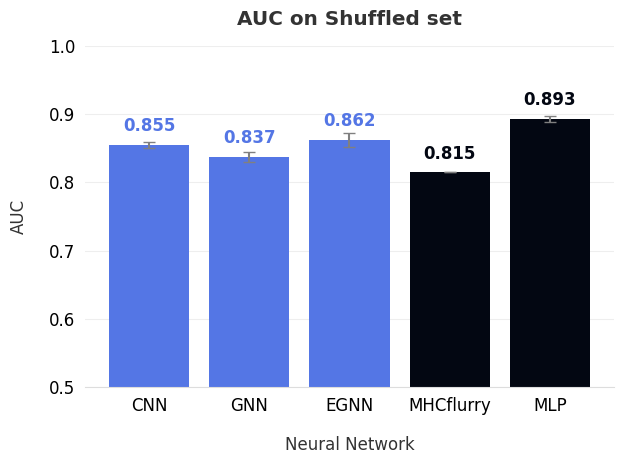

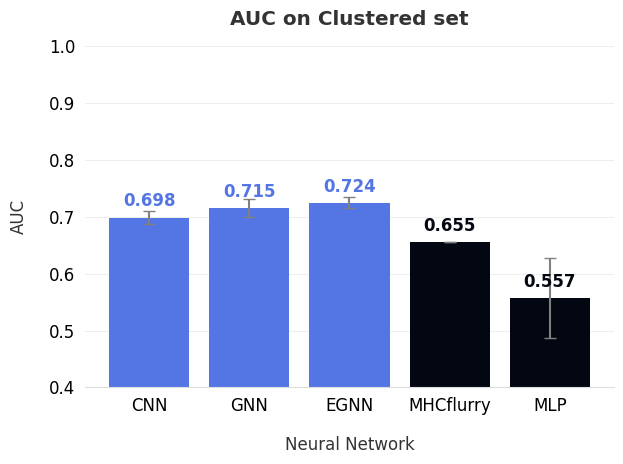

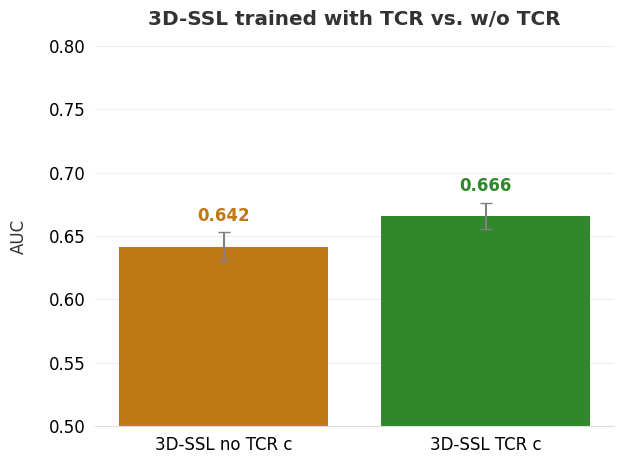

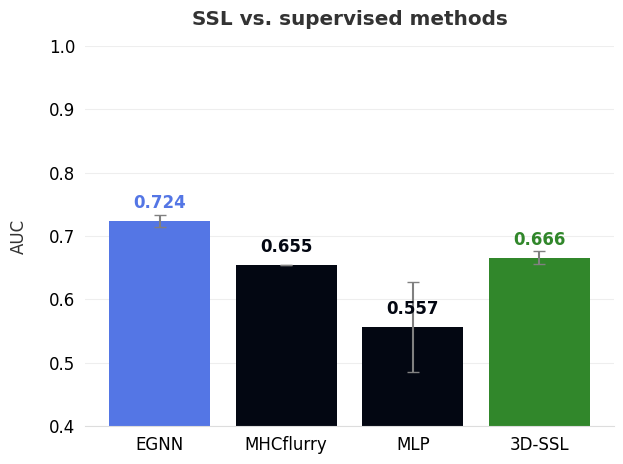

In [10]:
plt.rcParams['font.size'] = 12
# Plot StrB and SeqB shuffled
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [collected_shuffled_outputs[key]['total_auc'] for key in models]
error = [collected_shuffled_outputs[key]['auc_stdev'] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUC'
title='AUC on Shuffled set'
plot_barplot(x, y, error, color, xlabel, ylabel, title, save = f'/home/dmarz/3D-Vac/src/exploration/manuscript/figures/AUC_shuffled')

# Plot StrB and SeqB clustered
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [collected_allele_outputs[key]['total_auc']  for key in models]
error = [collected_allele_outputs[key]['auc_stdev'] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUC'
title='AUC on Clustered set'

plot_barplot(x, y, error, color, xlabel, ylabel, title, ylim=(0.4,1.0), save = f'/home/dmarz/3D-Vac/src/exploration/manuscript/figures/AUC_clust_allele')

# Plot SSL
# Could add best StrB and best SeqB method as comparison
#models = ['3D-SSL no TCR s', '3D-SSL TCR s', '3D-SSL no TCR c', '3D-SSL TCR c']
models = ['3D-SSL no TCR c', '3D-SSL TCR c']
x = models
y = [collected_allele_outputs[key]['total_auc'] for key in ['SSL_woT', 'SSL_T']] #  [collected_shuffled_outputs[key]['total_auc'] for key in ['SSL_woT', 'SSL_T']] 
error = [np.std([0.656, 0.647, 0.638, 0.622, 0.642]), collected_allele_outputs['SSL_T']['auc_stdev']]
#error = [collected_allele_outputs[key]['auc_stdev'] for key in ['SSL_woT', 'SSL_T']] # [collected_shuffled_outputs[key]['auc_stdev'] for key in ['SSL_woT', 'SSL_T']]
color = ['#c07715', '#31872b'] #['#c07715','#c59063', '#31872b', '#6e8e77']
#xlabel='Neural Network'
xlabel=''
ylabel='AUC'
title='3D-SSL trained with TCR vs. w/o TCR'

plot_barplot(x, y, error, color, xlabel, ylabel, title, ylim=(0.5, 0.8), save = f'/home/dmarz/3D-Vac/src/exploration/manuscript/figures/withTCR_woTCR')

# Plot SSL summary
# Could add best StrB and best SeqB method as comparison
models = ['EGNN', 'MHCflurry', 'MLP', '3D-SSL']
x = models
y = [collected_allele_outputs[key]['total_auc'] for key in ['EGNN', 'MHCflurry', 'MLP', 'SSL_T']]
error = [collected_allele_outputs[key]['auc_stdev'] for key in ['EGNN', 'MHCflurry', 'MLP', 'SSL_T']]
color = ['#5476E5', '#030712', '#030712', '#31872b']
xlabel=''
ylabel='AUC'
title='SSL vs. supervised methods'

plot_barplot(x, y, error, color, xlabel, ylabel, title, ylim=(0.4,1.0), save = f'/home/dmarz/3D-Vac/src/exploration/manuscript/figures/SSL_AUC')




### PLOT AUPRCs

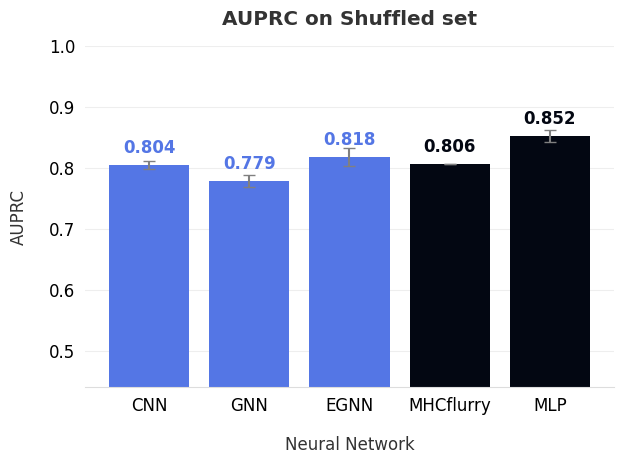

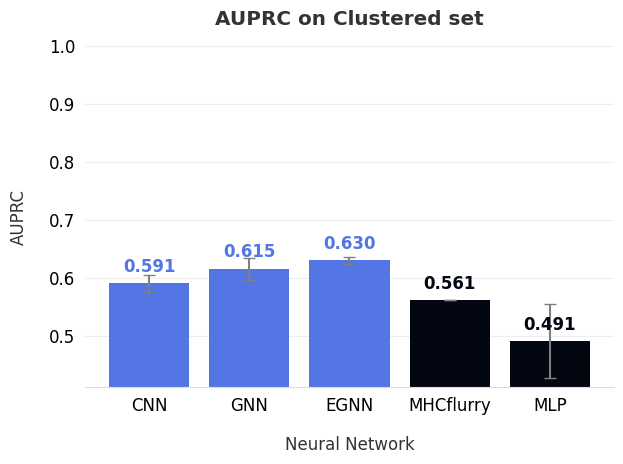

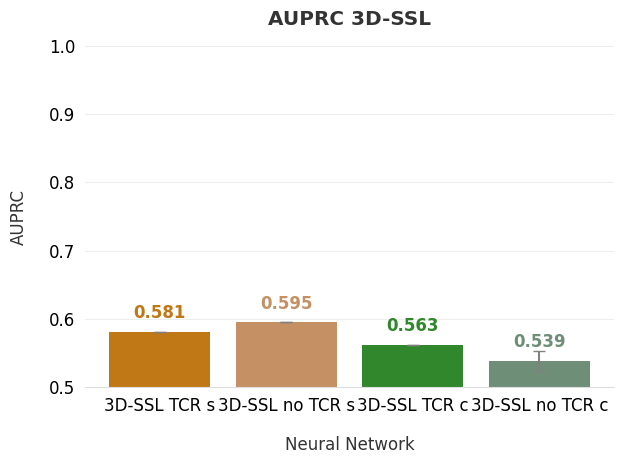

In [11]:
# Get AUPRC baseline values
clust_baseline = len(clust_dfi[clust_dfi['label']==1.0])/len(clust_dfi)
shuff_baseline = len(shuff_dfi[shuff_dfi['label']==1.0])/len(shuff_dfi)

plt.rcParams['font.size'] = 12

# Plot StrB and SeqB shuffled
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [collected_shuffled_outputs[key]['total_auprc'] for key in models]
error = [collected_shuffled_outputs[key]['auprc_stdev'] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUPRC'
title='AUPRC on Shuffled set'
plot_barplot(x, y, error, color, xlabel, ylabel, title, 
            ylim=(shuff_baseline, 1.0),
            save = f'/home/dmarz/3D-Vac/src/exploration/manuscript/figures/AUPRC_shuffled')

# Plot StrB and SeqB clustered
models = ['CNN', 'GNN', 'EGNN', 'MHCflurry', 'MLP']
x = models
y = [collected_allele_outputs[key]['total_auprc'] for key in models]
error = [collected_allele_outputs[key]['auprc_stdev'] for key in models]
color = ['#5476E5','#5476E5', '#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUPRC'
title='AUPRC on Clustered set'

plot_barplot(x, y, error, color, xlabel, ylabel, title, 
                ylim=(clust_baseline, 1.0),
                save = f'/home/dmarz/3D-Vac/src/exploration/manuscript/figures/AUPRC_clust_allele')

# Plot SSL
# Could add best StrB and best SeqB method as comparison
models = ['3D-SSL TCR s', '3D-SSL no TCR s', '3D-SSL TCR c', '3D-SSL no TCR c']
x = models
y = [collected_shuffled_outputs[key]['total_auprc'] for key in ['SSL_T', 'SSL_woT']] + [collected_allele_outputs[key]['total_auprc'] for key in ['SSL_T', 'SSL_woT']]
error = [collected_shuffled_outputs[key]['auprc_stdev'] for key in ['SSL_woT', 'SSL_T']] + [collected_allele_outputs[key]['auprc_stdev'] for key in ['SSL_woT', 'SSL_T']]
color = ['#c07715','#c59063', '#31872b', '#6e8e77']
xlabel='Neural Network'
ylabel='AUPRC'
title='AUPRC 3D-SSL'

plot_barplot(x, y, error, color, xlabel, ylabel, title, save = f'/home/dmarz/3D-Vac/src/exploration/manuscript/figures/AUPRC_SSL')




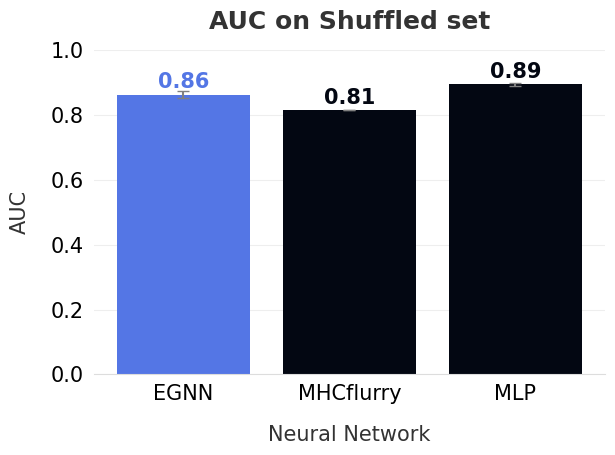

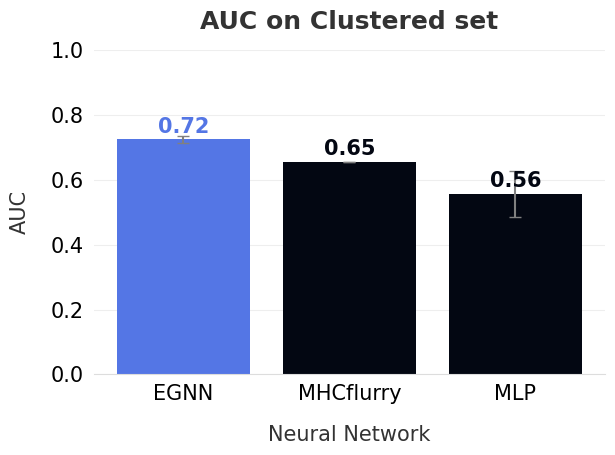

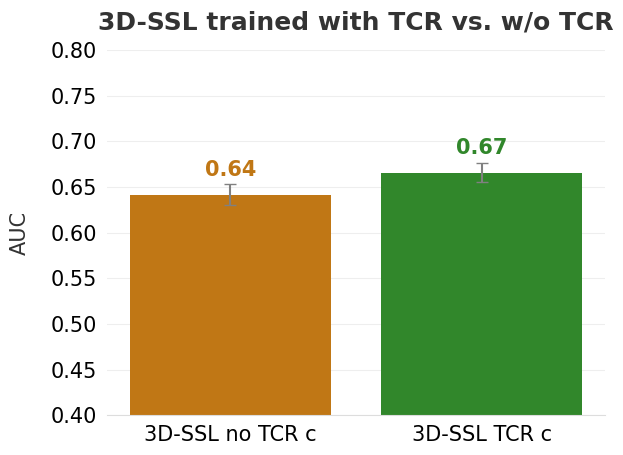

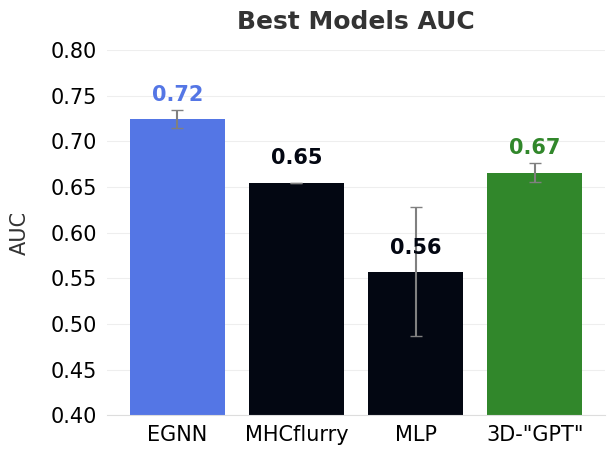

In [12]:
plt.rcParams['font.size'] = 15

# Plot StrB and SeqB shuffled for poster
models = ['EGNN', 'MHCflurry', 'MLP']
x = models
y = [collected_shuffled_outputs[key]['total_auc'] for key in models]
error = [collected_shuffled_outputs[key]['auc_stdev'] for key in models]
color = ['#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUC'
title='AUC on Shuffled set'
plot_barplot(x, y, error, color, xlabel, ylabel, title, 
             ylim=(0.0,1.0), decimals=2)

# Plot StrB and SeqB clustered for poster
models = ['EGNN', 'MHCflurry', 'MLP']
x = models
y = [collected_allele_outputs[key]['total_auc']  for key in models]
error = [collected_allele_outputs[key]['auc_stdev'] for key in models]
color = ['#5476E5', '#030712', '#030712']
xlabel='Neural Network'
ylabel='AUC'
title='AUC on Clustered set'

plot_barplot(x, y, error, color, xlabel, ylabel, title, 
             ylim=(0.0,1.0), decimals=2)

models = ['3D-SSL no TCR c', '3D-SSL TCR c']
x = models
y = [collected_allele_outputs[key]['total_auc'] for key in ['SSL_woT', 'SSL_T']] #  [collected_shuffled_outputs[key]['total_auc'] for key in ['SSL_woT', 'SSL_T']] 
error = [np.std([0.656, 0.647, 0.638, 0.622, 0.642]), collected_allele_outputs['SSL_T']['auc_stdev']]
#error = [collected_allele_outputs[key]['auc_stdev'] for key in ['SSL_woT', 'SSL_T']] # [collected_shuffled_outputs[key]['auc_stdev'] for key in ['SSL_woT', 'SSL_T']]
color = ['#c07715', '#31872b'] #['#c07715','#c59063', '#31872b', '#6e8e77']
#xlabel='Neural Network'
xlabel=''
ylabel='AUC'
title='3D-SSL trained with TCR vs. w/o TCR'

plot_barplot(x, y, error, color, xlabel, ylabel, title, ylim=(0.4, 0.8), decimals=2)

models = ['EGNN', 'MHCflurry', 'MLP', '3D-"GPT"']
x = models
y = [collected_allele_outputs[key]['total_auc'] for key in ['EGNN', 'MHCflurry', 'MLP', 'SSL_T']]
error = [collected_allele_outputs[key]['auc_stdev'] for key in ['EGNN', 'MHCflurry', 'MLP', 'SSL_T']]
color = ['#5476E5', '#030712', '#030712', '#31872b']
xlabel=''
ylabel='AUC'
title='Best Models AUC'

plot_barplot(x, y, error, color, xlabel, ylabel, title, ylim=(0.4,0.8), decimals=2)

In [13]:
shuff_baseline

0.4397801099450275

In [14]:
clust_baseline

0.4111933839792288